# Supervised methods 

Preparing data

In [16]:
# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from utils import * 
from utils_ml import *
import matplotlib.pyplot as plt

In [17]:
def plotprediction_TS(test_dates, final_predictions, test_labels):
    import seaborn as sns
    df_to_compare = pd.DataFrame({'date': test_dates, 'Actual': test_labels, 'Predicted': final_predictions})
    dfm = pd.melt(df_to_compare, id_vars=['date'], value_vars=['Actual', 'Predicted'], var_name='data', value_name='precip')
    f, axs = plt.subplots(1,2,
                      figsize=(12,5),
                      sharey=True)

    sns.regplot(data= df_to_compare,
                x="Actual",
                y="Predicted",
                ax=axs[0],
                )
    sns.lineplot(x='date', y='precip', hue = 'data', data=dfm, ax=axs[1])

In [18]:
# Paths
os.getcwd() 
DATADIR = '/Users/noeliaotero/Documents/CAS_ML/data/'

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'

In [19]:
DIRCSV  = DATADIR + 'TS_CH/'
l_files = glob.glob(os.path.join(DIRCSV, 'df*.csv'))
df_vars =  read_csv_files(l_files, DATE_START, DATE_END)

In [20]:
# read precipitaion
df_prec = get_precipitation_data ( DATADIR + 'TS_CH/precip_regions.csv', DATE_START, DATE_END)
# Select the right columns: date and reg_tot (all country)
df_prec = df_prec[['date','reg_tot']]

In [28]:
# Read Large scale-atmospheric PCs and Clusters
df_PCs = pd.read_csv(DATADIR + 'ERA5/PCdf.csv')
df_clusters =  pd.read_csv(DATADIR + 'ERA5/Cluster_spatialmean.csv')

In [15]:
# Merge everything
l_all = []
l_all.append(df_vars)
l_all.append(df_prec)
df_input = concat_dataframes(l_all)

In [154]:
df_input.head()

,date,1000,850,700,500,300,MSL,T2MMEAN,reg_tot
0,1979-01-01,670.4725,13147.572,27538.084,51563.137,85408.29,1009.0970,-9.09492,1.611
1,1979-01-02,1956.0348,14132.256,28140.230,51360.200,84393.94,1026.4789,-16.21680,3.927
2,1979-01-03,1836.2461,14219.614,28574.281,52375.900,86106.79,1024.0898,-13.92896,0.613
3,1979-01-04,713.6229,13306.500,28061.512,52525.293,86493.56,1009.1322,-13.54580,0.723
4,1979-01-05,1251.9210,13966.791,28859.885,53412.040,87216.22,1015.9122,-12.99600,0.122


Data exploration

Prepare the data 

In [155]:
yy_train = [1979,2015]
yy_test  = [2016,2020]
attributes = df_vars.columns[1:8]
ylabel = df_prec.columns[1]


array([[<AxesSubplot:xlabel='1000', ylabel='1000'>,
        <AxesSubplot:xlabel='850', ylabel='1000'>,
        <AxesSubplot:xlabel='700', ylabel='1000'>,
        <AxesSubplot:xlabel='500', ylabel='1000'>,
        <AxesSubplot:xlabel='300', ylabel='1000'>,
        <AxesSubplot:xlabel='MSL', ylabel='1000'>,
        <AxesSubplot:xlabel='T2MMEAN', ylabel='1000'>,
        <AxesSubplot:xlabel='reg_tot', ylabel='1000'>],
       [<AxesSubplot:xlabel='1000', ylabel='850'>,
        <AxesSubplot:xlabel='850', ylabel='850'>,
        <AxesSubplot:xlabel='700', ylabel='850'>,
        <AxesSubplot:xlabel='500', ylabel='850'>,
        <AxesSubplot:xlabel='300', ylabel='850'>,
        <AxesSubplot:xlabel='MSL', ylabel='850'>,
        <AxesSubplot:xlabel='T2MMEAN', ylabel='850'>,
        <AxesSubplot:xlabel='reg_tot', ylabel='850'>],
       [<AxesSubplot:xlabel='1000', ylabel='700'>,
        <AxesSubplot:xlabel='850', ylabel='700'>,
        <AxesSubplot:xlabel='700', ylabel='700'>,
        <AxesSubplot:

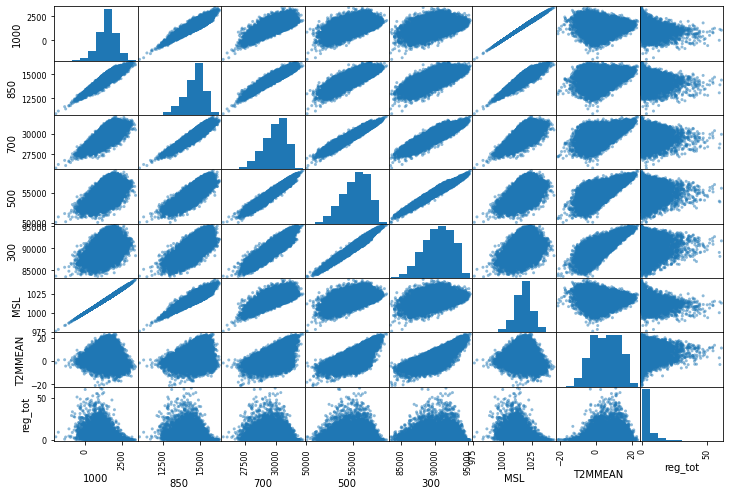

In [156]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

scatter_matrix(df_input[df_input.columns[1:9]], figsize=(12, 8))


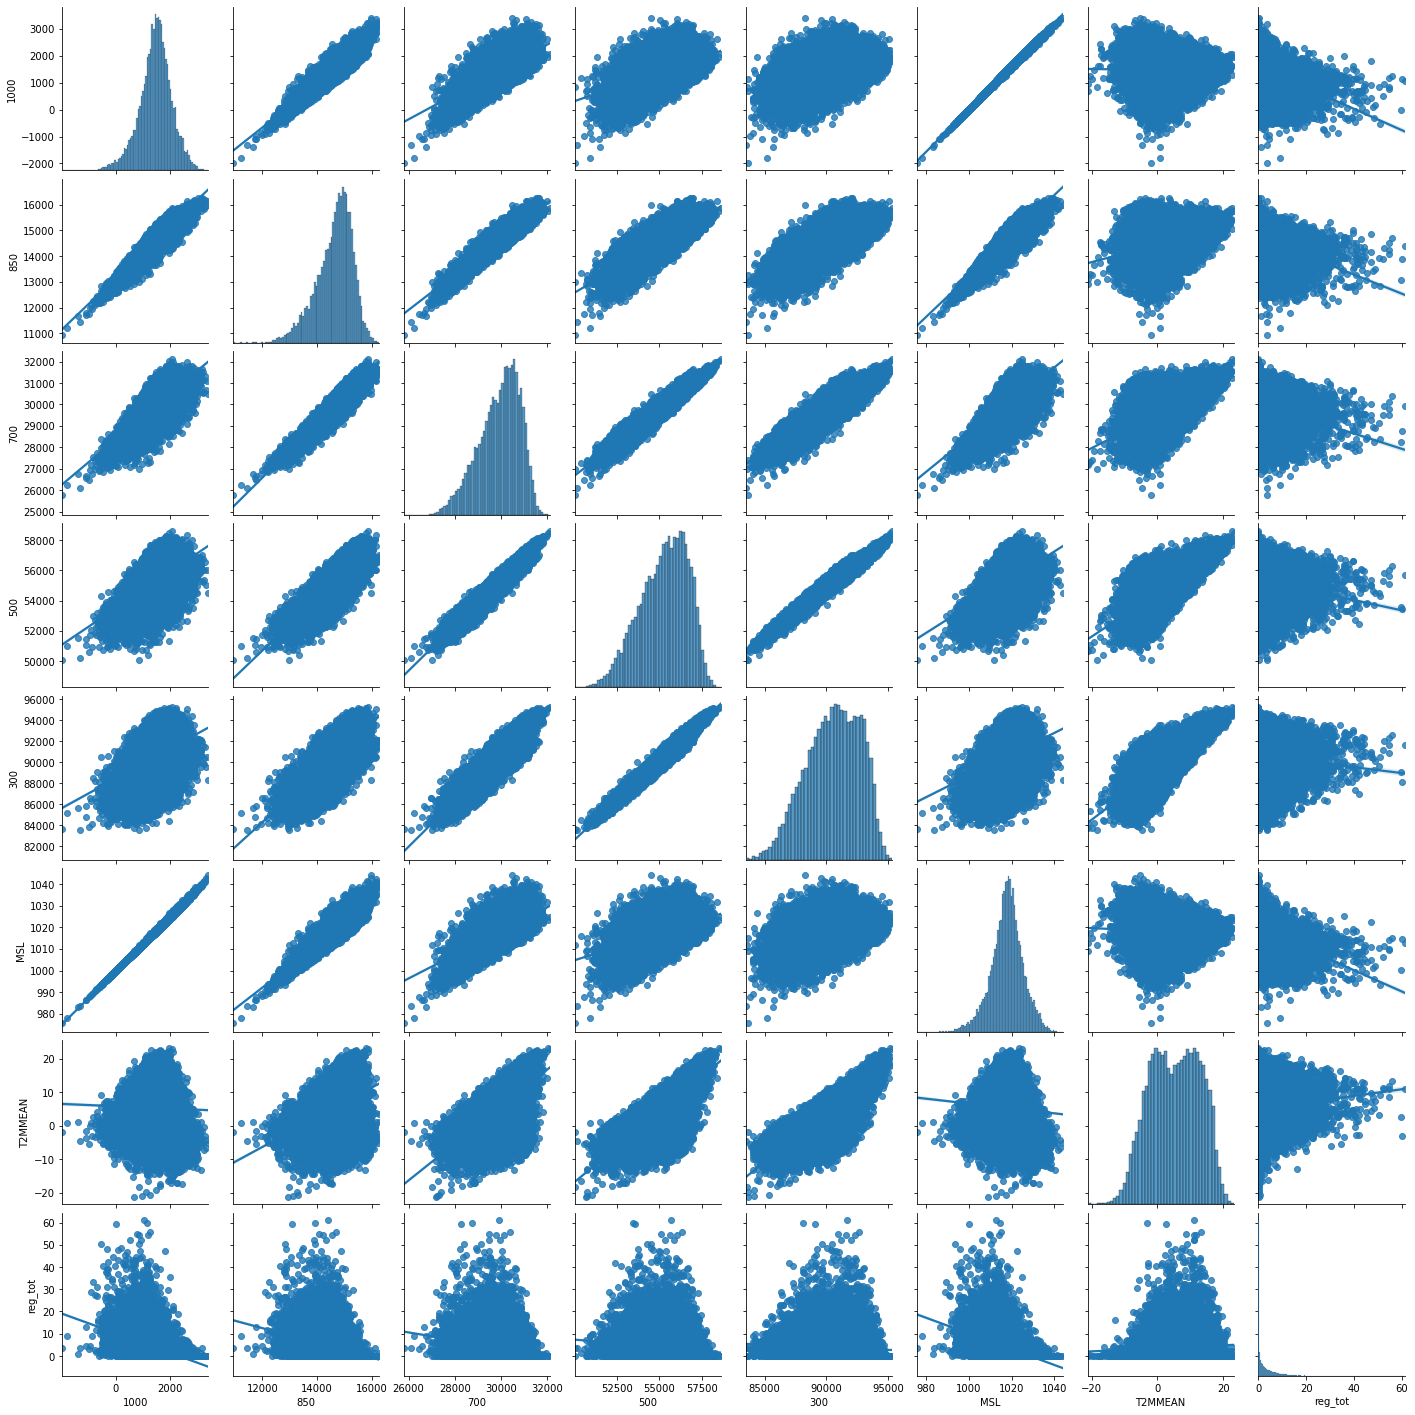

In [157]:
import seaborn
seaborn.pairplot(df_input, vars=df_input.columns[1:9],
                 kind='reg')  

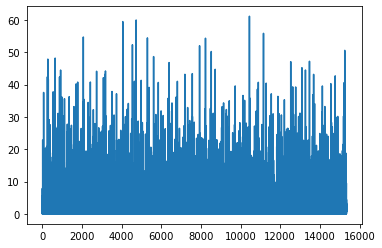

In [158]:
# Plot Time series
from matplotlib import pyplot
df_input['reg_tot'].plot()
pyplot.show()

In [159]:
train_labels.describe()

count    13514.000000
mean         3.811699
std          6.285343
min          0.000000
25%          0.027000
50%          0.969000
75%          5.053000
max         61.123000
Name: reg_tot, dtype: float64

In [160]:
train_dataset, train_labels, test_dataset, test_labels, train_dates, test_dates = split_data(df_input, yy_train, yy_test, attributes, ylabel)
train_dataset

,1000,850,700,500,300,MSL,T2MMEAN
0,670.4725,13147.5720,27538.084,51563.137,85408.290,1009.09700,-9.09492
1,1956.0348,14132.2560,28140.230,51360.200,84393.940,1026.47890,-16.21680
2,1836.2461,14219.6140,28574.281,52375.900,86106.790,1024.08980,-13.92896
3,713.6229,13306.5000,28061.512,52525.293,86493.560,1009.13220,-13.54580
4,1251.9210,13966.7910,28859.885,53412.040,87216.220,1015.91220,-12.99600
...,...,...,...,...,...,...,...
13509,2574.1172,15820.1750,31238.965,56673.836,91952.550,1031.60170,-1.63175
13510,2341.0386,15606.1300,31090.700,56641.086,92014.590,1028.72700,-1.98650
13511,2294.6145,15423.5100,30689.750,55916.074,91049.170,1028.37980,-1.61298
13512,2159.8462,15197.5625,30453.406,55788.844,91222.450,1026.89266,-1.83560


In [161]:
fpipeline = prepareData(train_dataset)
X_prep_train = fpipeline.fit_transform(train_dataset)
X_prep_test = fpipeline.fit_transform(test_dataset)

# Multiple linear regression

In [162]:
# Import some libraries
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [163]:
lr = LinearRegression(n_jobs=16)
lr.fit(X_prep_train, train_labels)

LinearRegression(n_jobs=16)

In [164]:
mse_train = mean_squared_error(train_labels, lr.predict(X_prep_train))
mse_test = mean_squared_error(test_labels, lr.predict(X_prep_test))
print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
print(f'Train RMSE = {np.sqrt(mse_train)}'); print(f'Test RMSE = {np.sqrt(mse_test)}')

Train MSE = 30.830335180123896
Test MSE = 28.435896875264184
Train RMSE = 5.552507107615793
Test RMSE = 5.332531938513278


Do we want to apply model selection?
RFE (Recursive feature elimination)

In [165]:
rfe = RFE(lr)             
rfe = rfe.fit(X_prep_train, train_labels)
mean_squared_error(train_labels, rfe.predict(X_prep_train))

31.332756455409466

In [166]:
def plot_result(x, y):

    fig, ax = plt.subplots()
    ax.scatter(test_labels, preds)
    ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

Apply cross-validation

In [167]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [168]:
lr_cv_mse = cross_val_score(lr, X_prep_train, train_labels, scoring='neg_mean_squared_error', cv=10)
# We got the negative average MSE for cross-validation (minimizing MSE is equivalent to maximizing the negative MSE)
lr_cv_mse.mean()
# The result is close to what we obtained before. The negative result 

-30.912465685882704

In [169]:
lin_rmse_scores = np.sqrt(-lr_cv_mse)
pd.Series(lin_rmse_scores).describe()

count    10.000000
mean      5.555228
std       0.240152
min       5.250950
25%       5.368364
50%       5.532139
75%       5.648966
max       5.945618
dtype: float64

In [170]:
print("Folds: " + str(len(lr_cv_mse)) + ", MSE: " + str(np.mean(np.abs(lr_cv_mse))) + ", STD: " + str(np.std(lr_cv_mse)))


Folds: 10, MSE: 30.912465685882704, STD: 2.5505990867927633


In [171]:
# get the coefficients
coeff_df = pd.DataFrame(lr.coef_, attributes, columns=['Coefficient'])
# makes some predictions
y_pred = lr.predict(X_prep_test)

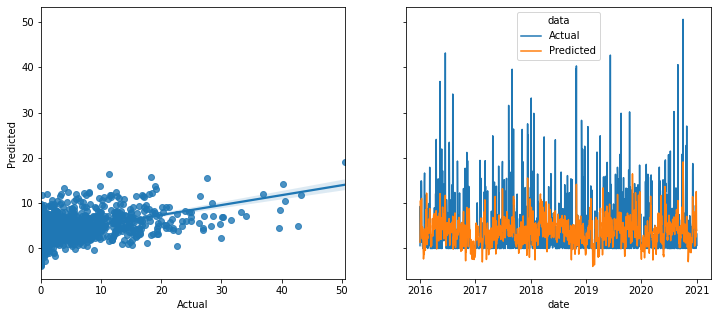

In [172]:
plotprediction_TS(test_dates, y_pred, test_labels)

# Random Forest

In [173]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_prepared_train, train_labels)
# make predictions
y_rf_pred = forest_reg.predict(X_prep_test)

In [174]:
mse_rf_train = mean_squared_error(train_labels, forest_reg.predict(X_prep_train))
mse_rf_test = mean_squared_error(test_labels, forest_reg.predict(X_prep_test))
print(f'Train MSE = {mse_rf_train}'); print(f'Test MSE = {mse_rf_test}')
print(f'Train RMSE = {np.sqrt(mse_rf_train)}'); print(f'Test RMSE = {np.sqrt(mse_rf_test)}')

Train MSE = 4.092623124391668
Test MSE = 27.510985396634215
Train RMSE = 2.023023263433139
Test RMSE = 5.245091552740925


In [175]:
# Now it can be noted overfitting problem, the RMSE is much higher for the test 
# Tunning parameter
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
# Create the parameter grid based on the results of random search 
    
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_prep_train, train_labels)
best_params = grid_search.best_params_

In [176]:
print ("Best Score:" , grid_search.best_score_)
print ("Best params:", best_params)

Best Score: -30.432558261553442
Best params: {'max_features': 4, 'n_estimators': 30}


In [177]:
forest_GCV_reg = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
forest_GCV_reg.fit(X_prep_train,train_labels)

RandomForestRegressor(max_features=4, n_estimators=30, n_jobs=-1)

In [178]:
y_rf_cv_predict = forest_GCV_reg.predict(X_prep_test)


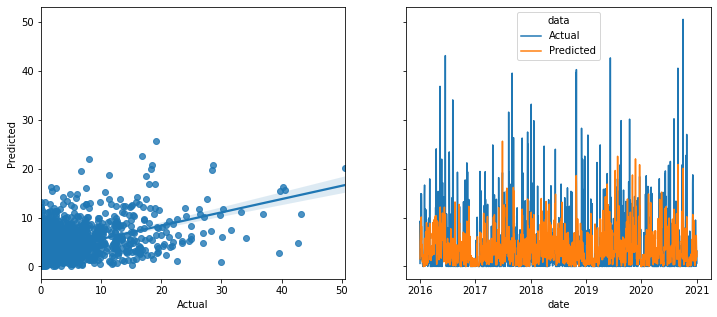

In [179]:
plotprediction_TS(test_dates, y_rf_cv_predict, test_labels)

In [180]:
features_importance = forest_GCV_reg.feature_importances_

In [182]:
sorted_features_importance = sorted(zip(features_importance, attributes), reverse=True)

In [183]:
sorted_features_importance

[(0.22024000262125576, 'MSL'),
 (0.1544795566357838, '1000'),
 (0.14648560248642126, 'T2MMEAN'),
 (0.14310032182390964, '300'),
 (0.12048626609746431, '850'),
 (0.10821902756378764, '700'),
 (0.10698922277137769, '500')]